# Import Statements

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from graph_util.visualization_util import make_graph_visual
from scheduling_util.modified_etf import Mod_ETF
from scheduling_util.consolidated_functions import opt_schedule_given_ordering
from scheduling_util.heuristics import native_rescheduler
from graph_util.random_graph_functions import random_all_fork, random_all_join
from graph_util.erdos_renyi_dag import er_dag
from scheduling_util.approx_pseudosizes import speed_to_psize

# Training Data

In [2]:
feature_id = [ 'num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels']    

def get_feature_set(G, psize):
    
    lst = []
    out_bet_lst = nx.algorithms.out_degree_centrality(G)
    trophic_lst = nx.algorithms.trophic_levels(G)
    for node in G.nodes:
        # print("in betweennes", in_bet)
        out_bet = out_bet_lst[node]
        trophic = trophic_lst[node]
        # print("out_betweennes", out_bet)
        descendants = list(nx.algorithms.dag.descendants(G, node))
        descendants.append(node)
        num_descendants = len(descendants) 
        lst.append((num_descendants, out_bet, trophic, psize[node]))      
    return lst

In [3]:
data = []

tie_breaking_rule = 2
# num_tasks = 15
# num_machines = 3
probability = 0.3

for i in range(1, 20):
    print("I is ", i)
    for k in range(5):  
        num_tasks = i + 5
        num_machines = 3
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        G, _ = er_dag(num_tasks, probability)
        assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        if speeds[0] !=-1:
            psize = speed_to_psize(speeds)
            feature_set = get_feature_set(G, psize)
                # make_graph_visual(G, num_tasks)
            data = data + feature_set

I is  1
I is  2
I is  3
I is  4
I is  5
I is  6
I is  7
I is  8
I is  9
I is  10
I is  11
I is  12
I is  13
I is  14
I is  15
I is  16
I is  17
I is  18
I is  19


In [4]:
#load data into Dataframe
df = pd.DataFrame.from_records(data, columns=['num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])
df[['num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels']].to_csv("train_data.csv")
df[["psize"]].to_csv("train_labels.csv")

In [5]:
import statsmodels.api as sm

X = df[['num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels']]
X = sm.add_constant(X)
Y = df['psize']
model=sm.OLS(Y, X.astype(float)).fit()
predictions=model.predict(X)
print_model=model.summary()
print(print_model)


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
lr = LinearRegression()
import numpy as np
lr.fit(X, Y)
print(f'R-Squared : {lr.score(X, Y)}')
print(lr.get_params())
print(lr.coef_)
print(lr.intercept_)

                            OLS Regression Results                            
Dep. Variable:                  psize   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1214.
Date:                Thu, 30 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:24:58   Log-Likelihood:                -2556.6
No. Observations:                1345   AIC:                             5121.
Df Residuals:                    1341   BIC:                             5142.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

# Train Model

In [6]:
import numpy as np
coefficients = np.array(model.params)
print(coefficients)

[0.25721353 0.50490213 2.30024368 0.17312282]


In [7]:
step_size = 0.01

In [8]:
from itertools import product
from copy import deepcopy

def compute_cost(w, t, s):
    '''
    Given weights w, time intervals t, and speeds s, compute the cost of the schedule; 
    returns total cost as well as separate power and time components.
    '''
    power = 0
    time = 0
    #print(f"compute cost intervals are {t}")
    for j in range(len(s)):
        if t[j] == -1:
            return -1, -1, -1
        power += w[j] * s[j]
        time += t[j][1]
    total_cost = power + time
    return total_cost, power, time

def psize_to_speed(psize):
    return [np.sqrt(psize[i])for i in range(len(psize))]

def predict(coef, inputs):
    sum= coef[0]
    for i in range(len(coef[1:])):
        sum += coef[i]*inputs[i]
    return sum

def combinations(coef, G, w, x, order):
    # print("__________________________-")
    curr_min_objective = np.inf
    curr_min_coef = deepcopy(coef)
    min_cost, min_power, min_time = np.inf, np.inf, np.inf
    all_combinations = list(product((-1, 1), repeat=4))
    for combo in all_combinations:
        temp_coef = deepcopy(coef)
        for i in range(len(combo)):
            if combo[i] == 1:
                temp_coef[i] += step_size
            else:
                temp_coef[i] -= step_size
        #print(f"temp_coef is {temp_coef}")
        psizes = np.matmul(temp_coef, x)
        #print(f"Pseudosizes are {psizes}")
        speeds = psize_to_speed(psizes)
        #print(f"Speeds are {speeds}")
        #print(f"Order is {order}")
        time_intervals = native_rescheduler(deepcopy(G), deepcopy(speeds), deepcopy(w), deepcopy(order))
        #print(f"intervals {time_intervals}")
        cost, power, time = compute_cost(w,time_intervals ,speeds)
        print(f"Cost is {cost}, Power is {power}, time is {time}")
        if cost <= min_cost:
            min_cost, min_power, min_time = cost, power, time
            curr_min_coef = deepcopy(temp_coef)
        
    return min_cost, min_power, min_time, curr_min_coef

In [9]:
data = []
greedy_objectives = []
lr_objective = []
lengths = []
tie_breaking_rule = 2
greedy_psizes = []
lr_psizes = []
# num_tasks = 15
# num_machines = 3
probability = 0.3
coefficients_copy = deepcopy(coefficients)
for i in range(1, 20):
    print("I is ", i)
    for k in range(5):  
        num_tasks = i + 5
        num_machines = 3
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        G, _ = er_dag(num_tasks, probability)
        assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        psize = speed_to_psize(speeds)
        # print(f"Greedy psizes are {psize}")
        cost, power, time = compute_cost(w, intervals, speeds)
        print("Linear Regression")
        print("_______________________")
        if cost != -1:
            greedy_objectives.append([cost, power, time])
            feature_set = get_feature_set(G, psize)
            # make_graph_visual(G, num_tasks)
            # data = data + feature_set
            df = pd.DataFrame.from_records(feature_set, columns=['num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels','psize'])
            X = df[['num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels']]
            X['ones'] =1
            X = X[['ones','num_descendants', 'out_degree_betweenness_centrality', 'trophic_levels' ]]
            X = X.to_numpy()
            X = np.transpose(X)
            # Y = df[['psize']].to_numpy()
            lr_cost, lr_power, lr_time, lr_min_coef = combinations(coefficients, G, w, X, etf.order)
            print(f"Coefficients: {lr_min_coef}")
            coefficients = lr_min_coef
            # X = sm.add_constant(X)
            # lr_psize = lr.predict(feature_set)
            # greedy_psizes.append(psize)
            # lr_psizes.append(lr_psize)
            # lr_speeds = psize_to_speed(lr_psize)
            # lr_time_intervals = native_rescheduler(G, lr_speeds, w, etf.order)
            # lr_cost, lr_power, lr_time = compute_cost(w,lr_time_intervals ,lr_speeds)
            lr_objective.append([lr_cost, lr_power, lr_time])
            lengths.append(len(G))
            print(f"Greedy: {cost}  LR: {lr_cost} length: {lengths[-1]}")

I is  1
Linear Regression
_______________________
Cost is 15.85258221617083, Power is 7.809306883528963, time is 8.043275332641867
Cost is 15.85872959715526, Power is 7.90082006067471, time is 7.9579095364805505
Cost is 15.852378471443092, Power is 7.814400192817262, time is 8.03797827862583
Cost is 15.858584244032219, Power is 7.905885751805348, time is 7.952698492226871
Cost is 15.848089484749782, Power is 7.888772432709263, time is 7.959317052040518
Cost is 15.855776397288654, Power is 7.9794501638340325, time is 7.8763262334546225
Cost is 15.848005679981009, Power is 7.893810749004693, time is 7.954194930976316
Cost is 15.855747328319719, Power is 7.9844617187522005, time is 7.8712856095675185
Cost is 15.853061248926837, Power is 7.857016983314772, time is 7.996044265612065
Cost is 15.860361102039874, Power is 7.947856827878134, time is 7.91250427416174
Cost is 15.852902829715292, Power is 7.862089472023786, time is 7.990813357691506
Cost is 15.860259569145084, Power is 7.952902054

# Set Trained Coefficients to linear model

In [10]:
print(coefficients)
lr.coef_ = coefficients

[0.34721353 0.51490213 2.29024368 0.08312282]


# Test the Model

In [11]:
data = []
greedy_objectives = []
lr_objective = []
lengths = []
tie_breaking_rule = 2
greedy_psizes = []
lr_psizes = []
# num_tasks = 15
# num_machines = 3
probability = 0.3

for i in range(1, 20):
    print("I is ", i)
    for k in range(5):  
        num_tasks = i + 5
        num_machines = 3
        w = [1 for _ in range(num_tasks)]
        s = [1 for _ in range(num_tasks)]
        p = [1 for _ in range(num_tasks)]
        G, _ = er_dag(num_tasks, probability)
        assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
        etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
        intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
        psize = speed_to_psize(speeds)
        cost, power, time = compute_cost(w, intervals, speeds)
        if cost != -1:
            greedy_objectives.append([cost, power, time])
            feature_set = get_feature_set(G, psize)
            # make_graph_visual(G, num_tasks)
            # data = data + feature_set
            df = pd.DataFrame.from_records(feature_set, columns=['num_descendants',  'out_degree_betweenness_centrality', 'trophic_levels','psize'])
            X = df[[ 'num_descendants',  'out_degree_betweenness_centrality', 'trophic_levels']]
            X = sm.add_constant(X)
            lr_psize = lr.predict(feature_set)
            greedy_psizes.append(psize)
            lr_psizes.append(lr_psize)
            lr_speeds = psize_to_speed(lr_psize)
            lr_time_intervals = native_rescheduler(G, lr_speeds, w, etf.order)
            lr_cost, lr_power, lr_time = compute_cost(w,lr_time_intervals ,lr_speeds)
            lr_objective.append([lr_cost, lr_power, lr_time])
            lengths.append(len(G))

I is  1


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  2


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  3


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  4


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  5


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  6


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  7


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  8


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  9


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  10


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  11


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  12


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  13


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  14


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  15


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  16


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  17


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


I is  18


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

I is  19


/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegressi

# Graph the results

In [12]:
print("greedy objectives\n",greedy_objectives)
print("lr_objectives\n",lr_objective)
print(lengths)

greedy objectives
 [[15.313699999999999, 7.656839999999999, 7.65686], [15.12096, 7.56047, 7.560490000000001], [15.4641, 7.73205, 7.73205], [15.19151, 7.595739999999999, 7.59577], [14.48528, 7.24264, 7.24264], [17.94939, 8.97468, 8.97471], [17.949379999999998, 8.974689999999999, 8.974689999999999], [17.94939, 8.97468, 8.97471], [18.05195, 9.025970000000001, 9.02598], [19.120959999999997, 9.560469999999999, 9.56049], [23.87655, 11.938270000000001, 11.93828], [22.24191, 11.12095, 11.12096], [22.63629, 11.31815, 11.31814], [23.14251, 11.57126, 11.57125], [23.65686, 11.828420000000001, 11.82844], [27.220730000000003, 13.61036, 13.610370000000001], [26.421519999999997, 13.210759999999999, 13.210759999999999], [29.612590000000004, 14.806280000000001, 14.806310000000003], [26.80929, 13.404630000000001, 13.40466], [24.877570000000002, 12.438790000000001, 12.438780000000001], [28.8776, 14.438790000000001, 14.43881], [28.87759, 14.438780000000001, 14.43881], [29.52308, 14.76155, 14.76153], [36.42

In [13]:
objective_comparisons = [g[0]/l[0] for g, l in zip(greedy_objectives, lr_objective)]
power_comparisons = [g[1]/l[1] for g, l in zip(greedy_objectives, lr_objective)]
time_comparisons = [g[2]/l[2] for g, l in zip(greedy_objectives, lr_objective)]

print("objective ratio \n", objective_comparisons)
print("power comparisons \n", power_comparisons)
print("time comparisons \n", time_comparisons)

objective ratio 
 [0.8812400062371214, 0.8520341765084591, 0.8336901900239595, 0.8568488799524487, 0.9015147976339345, 0.9206337168976388, 0.8741338585476799, 0.8657169832805398, 0.8662109722553517, 0.8638399965319989, 0.8353932681915263, 0.8763244876613069, 0.8772391891978458, 0.8449597603977984, 0.8435400991162255, 0.8544566167544713, 0.8527678901398369, 0.8242807714465725, 0.8206109548207956, 0.8702167210914449, 0.9035034669395956, 0.8897788516307228, 0.8517085857330949, 0.8487771982519169, 0.8962708544280612, 0.8505092510398025, 0.881832903108391, 0.8758180621808895, 0.8954334961835315, 0.8694858606318131, 0.8928554073333299, 0.8816328197536935, 0.8523550136816406, 0.8720436222137342, 0.8290962010082503, 0.887767565879542, 0.8806831252105167, 0.8819074079929958, 0.8758680171585297, 0.8497658429236569, 0.8820602452198637, 0.8562275808415034, 0.8792911708478702, 0.8621730832959216, 0.8783451015813307, 0.8186897223416748, 0.8242645105497068, 0.8625908561604191, 0.8852894924786571, 0.8

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

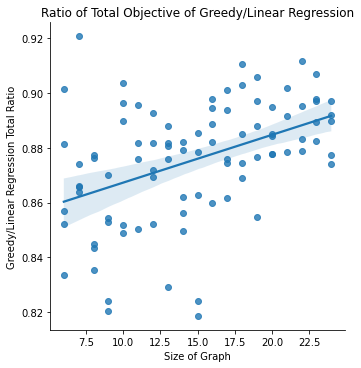

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

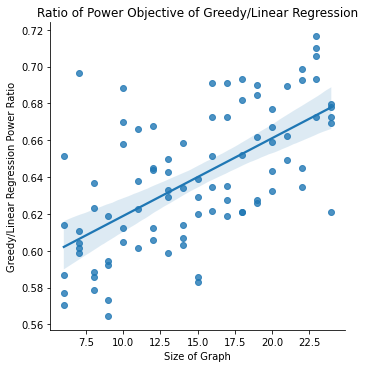

/home/vivek/Documents/Caltech/caltech_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1152x576 with 0 Axes>

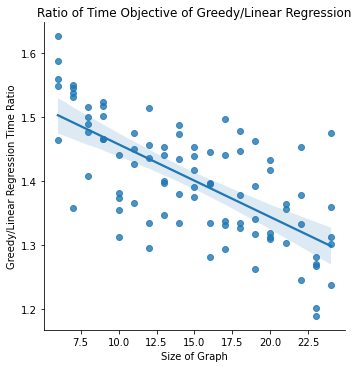

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# # Run model on test data and visualize prediction accuracy
# y_hat = lr.predict(X_test)
# print("predictions are ",y_hat)
# plt.figure(figsize=(16,8))
# sns.distplot(y_hat, hist = False, label = f'Predicted Pseudosize')
# sns.distplot(Y_test, hist = False, label = f'Actual Pseudosize')
# plt.title(f'Actual vs Predicted Pseudosize')
# plt.xlabel('Pseudosize')
# plt.ylabel('Density')
# plt.show()
plt_df = pd.DataFrame.from_dict({"objective_ratio": objective_comparisons, "power_ratio": power_comparisons, "time_ratio":time_comparisons, "size":lengths})

plt.figure(figsize=(16,8))
sns.lmplot("size", "objective_ratio", plt_df, order=1)
plt.title("Ratio of Total Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Total Ratio")
plt.show()

plt.figure(figsize=(16,8))
sns.lmplot("size", "power_ratio", plt_df, order=1)
plt.title("Ratio of Power Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Power Ratio")
plt.show()

plt.figure(figsize=(16,8))
sns.lmplot("size", "time_ratio", plt_df, order=1)
plt.title("Ratio of Time Objective of Greedy/Linear Regression")
plt.xlabel("Size of Graph")
plt.ylabel("Greedy/Linear Regression Time Ratio")
plt.show()